<div style='text-align: center;'>
    <img src='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSQzJzIHdangJTrH2mFXFgsLjuLCjpfXXwbxg&usqp=CAU' width='100'/>
    <h1>Sharif University of Technology</h1>
    <h2>Natural Language Processing</h2>
    <h3>Final Project</h3>
    <h4>Spoiler classification and summary generation</h4>
    <p><strong>Authors:</strong> Ali Nikkhah, Ramtin Khoshnevis, Sarina Zahedi</p>
    <p><strong>(Equal Contribution)</strong></p>
</div>
<hr/>


In [1]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
import string

# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

--------------------------------------------------------------------------------------------------------------------------------------


### **1. Load the Dataset**


In [2]:
import pandas as pd
import json
import torch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the dataset
file_path = '/kaggle/input/imdb-spoiler-dataset/IMDB_reviews.json'
data = []
with open(file_path, 'r') as file:
    for line in file:
        data.append(json.loads(line))

df = pd.DataFrame(data)


### **2. Exploratory Data Analysis (EDA)**

In [3]:
from tabulate import tabulate
import numpy as np

# Basic info
info = df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573913 entries, 0 to 573912
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   review_date     573913 non-null  object
 1   movie_id        573913 non-null  object
 2   user_id         573913 non-null  object
 3   is_spoiler      573913 non-null  bool  
 4   review_text     573913 non-null  object
 5   rating          573913 non-null  object
 6   review_summary  573913 non-null  object
dtypes: bool(1), object(6)
memory usage: 26.8+ MB


In [4]:
# Describe the dataset
description = df.describe()


# Check for missing values
missing_values = df.isnull().sum()


# Distribution of spoiler vs. non-spoiler
spoiler_distribution = df['is_spoiler'].value_counts(normalize=True)

# Length of reviews
df['review_length'] = df['review_text'].apply(len)
review_length_description = df['review_length'].describe()



In [5]:
# Display the results

print("\nMissing Values:")
print(tabulate(missing_values.items(), headers=["Column", "Missing Values"], tablefmt="pretty"))

print("\nSpoiler vs. Non-Spoiler Distribution:")
print(tabulate(spoiler_distribution.items(), headers=["Is Spoiler", "Proportion"], tablefmt="pretty"))

print("\nReview Length Description:")
print(tabulate(review_length_description.items(), headers=["Statistic", "Value"], tablefmt="pretty"))


Missing Values:
+----------------+----------------+
|     Column     | Missing Values |
+----------------+----------------+
|  review_date   |       0        |
|    movie_id    |       0        |
|    user_id     |       0        |
|   is_spoiler   |       0        |
|  review_text   |       0        |
|     rating     |       0        |
| review_summary |       0        |
+----------------+----------------+

Spoiler vs. Non-Spoiler Distribution:
+------------+---------------------+
| Is Spoiler |     Proportion      |
+------------+---------------------+
|   False    | 0.7370263437141169  |
|    True    | 0.26297365628588304 |
+------------+---------------------+

Review Length Description:
+-----------+--------------------+
| Statistic |       Value        |
+-----------+--------------------+
|   count   |      573913.0      |
|   mean    | 1460.5535246631457 |
|    std    | 1125.577018615146  |
|    min    |        18.0        |
|    25%    |       719.0        |
|    50%    |     

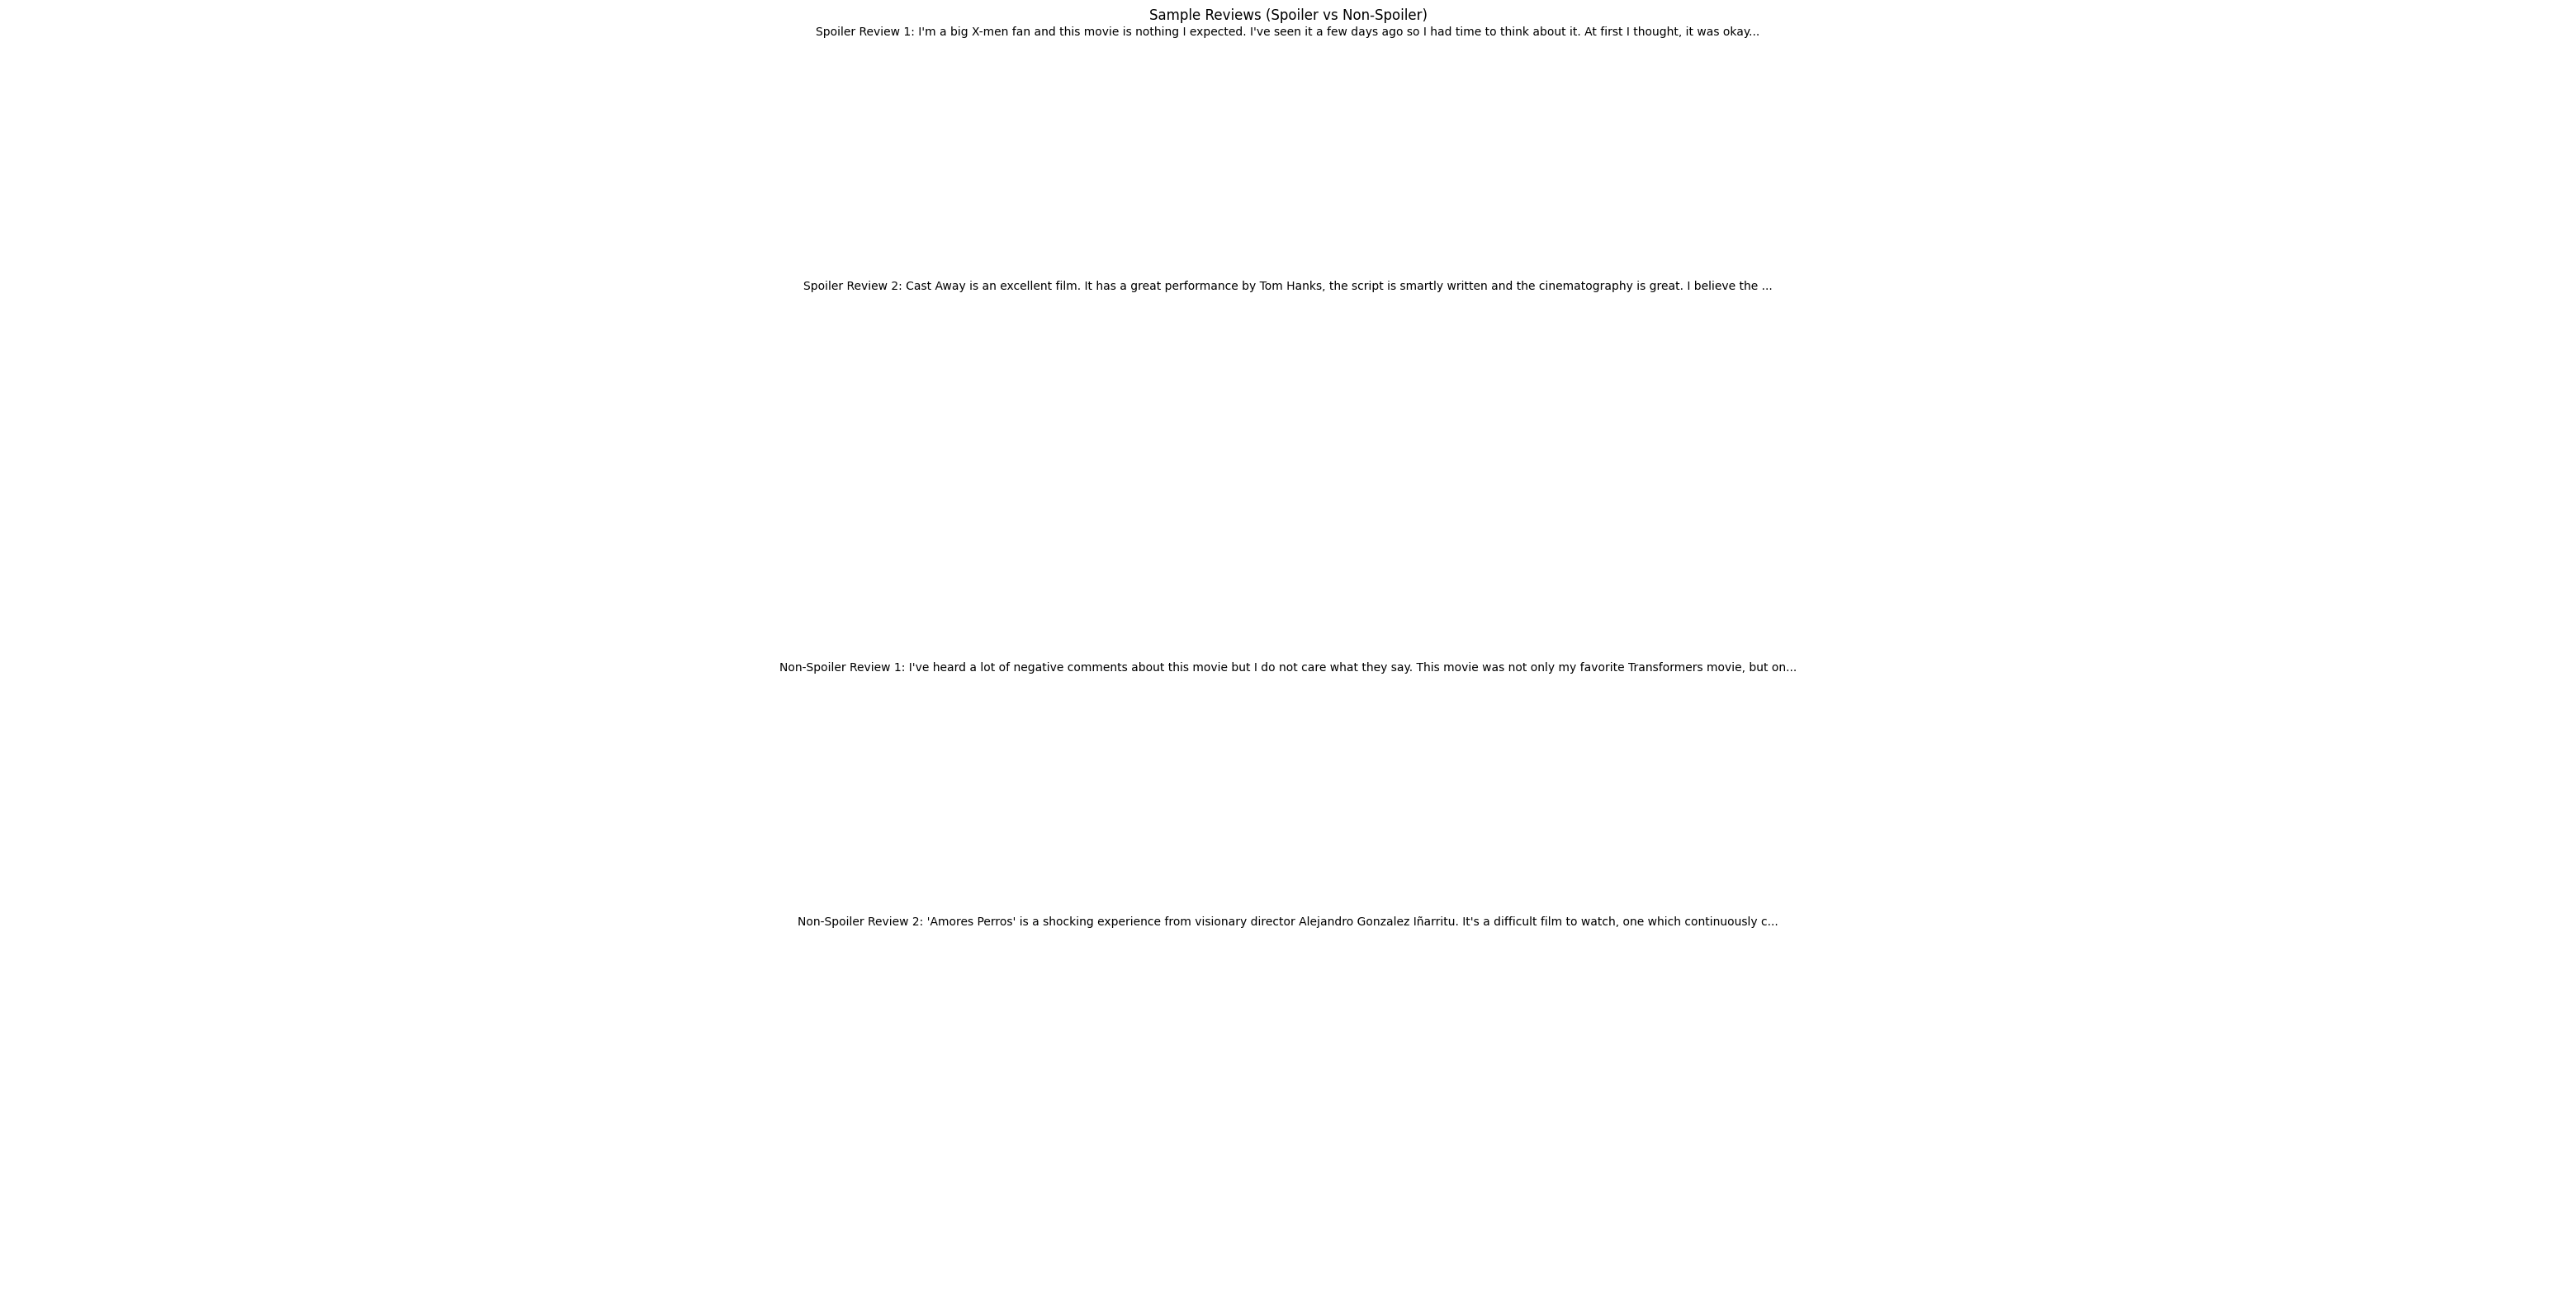

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot some samples of the dataset
sample_size = 2

spoiler_samples = df[df['is_spoiler'] == True].sample(sample_size)
non_spoiler_samples = df[df['is_spoiler'] == False].sample(sample_size)

plt.figure(figsize=(40, 20))

# Spoiler samples
for i, review in enumerate(spoiler_samples['review_text']):
    plt.text(0.5, 1.0 - i*0.2, f"Spoiler Review {i+1}: {review[:150]}...", ha='center', va='top', wrap=True)

# Non-Spoiler samples
for i, review in enumerate(non_spoiler_samples['review_text']):
    plt.text(0.5, 0.5 - i*0.2, f"Non-Spoiler Review {i+1}: {review[:150]}...", ha='center', va='top', wrap=True)

plt.axis('off')
plt.title('Sample Reviews (Spoiler vs Non-Spoiler)')
plt.show()


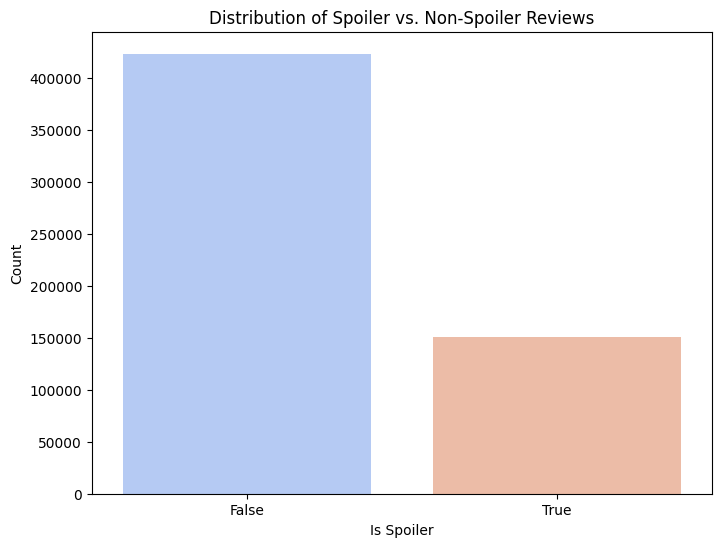

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


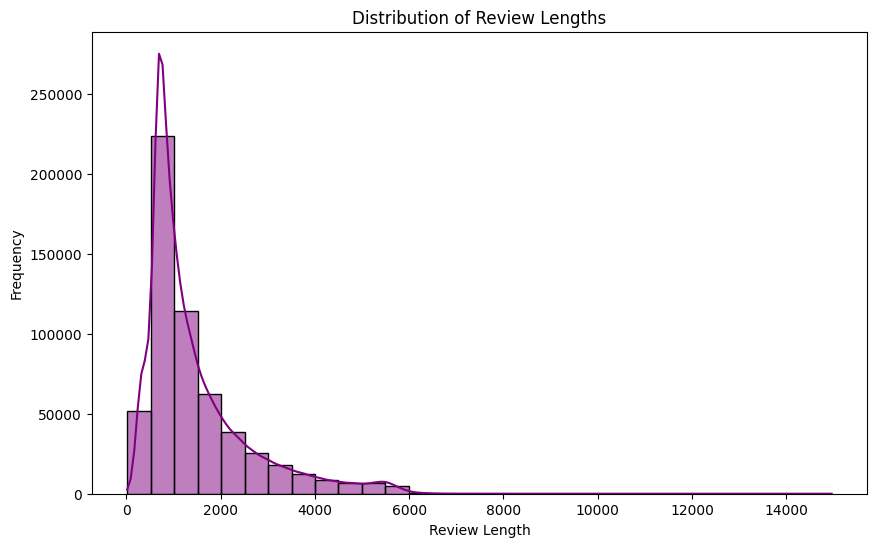

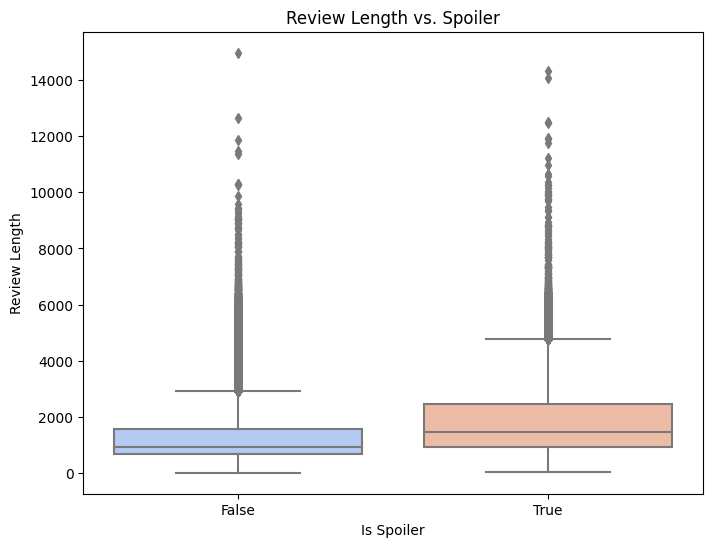

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of spoilers vs. non-spoilers
plt.figure(figsize=(8, 6))
sns.countplot(x='is_spoiler', data=df, palette='coolwarm')
plt.title('Distribution of Spoiler vs. Non-Spoiler Reviews')
plt.xlabel('Is Spoiler')
plt.ylabel('Count')
plt.show()

# Plot the distribution of review lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], kde=True, bins=30, color='purple')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

# Correlation between review length and is_spoiler
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_spoiler', y='review_length', data=df, palette='coolwarm')
plt.title('Review Length vs. Spoiler')
plt.xlabel('Is Spoiler')
plt.ylabel('Review Length')
plt.show()


### **2.B. Down sample to make two calsses uniform**

In [8]:
class_counts = df['is_spoiler'].value_counts()
min_class_count = class_counts.min()

# Downsample each class to have the same number of instances as the smallest class
df_balanced = pd.DataFrame()  # Create an empty DataFrame to store the balanced data

for label in class_counts.index:
    df_balanced = pd.concat([
        df_balanced,
        df[df['is_spoiler'] == label].sample(n=min_class_count, random_state=42)
    ])

# Shuffle the DataFrame to mix the classes well
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [9]:
df=df_balanced

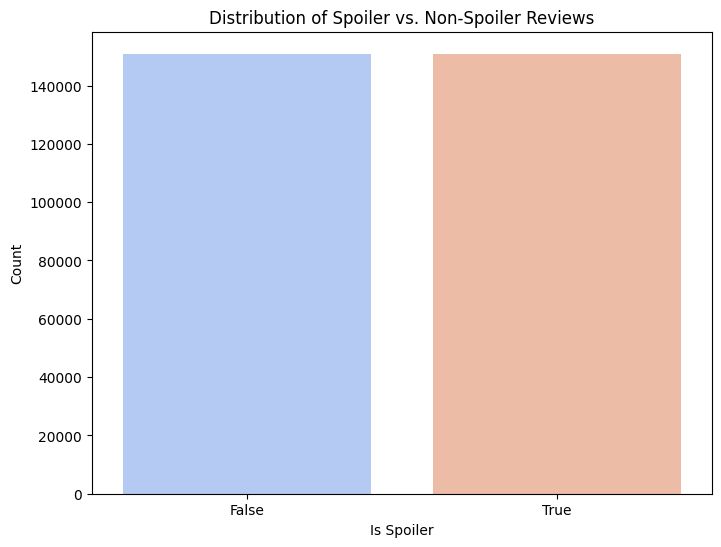

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


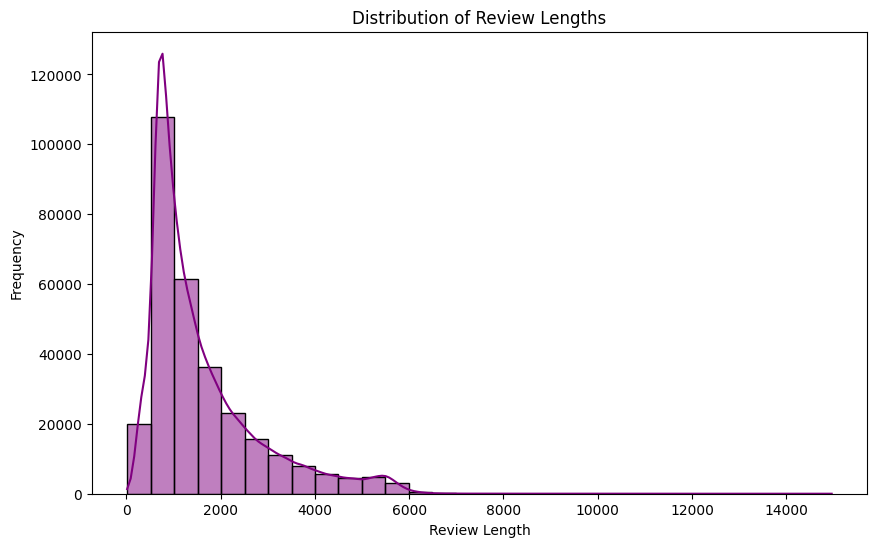

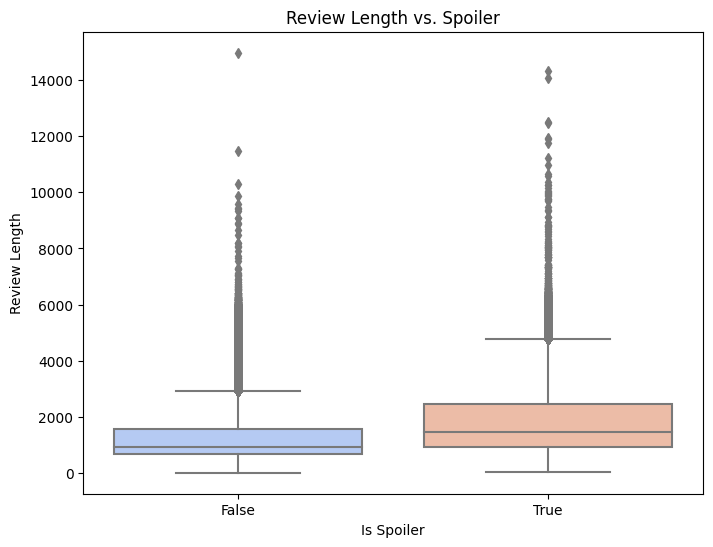

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of spoilers vs. non-spoilers
plt.figure(figsize=(8, 6))
sns.countplot(x='is_spoiler', data=df, palette='coolwarm')
plt.title('Distribution of Spoiler vs. Non-Spoiler Reviews')
plt.xlabel('Is Spoiler')
plt.ylabel('Count')
plt.show()

# Plot the distribution of review lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], kde=True, bins=30, color='purple')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

# Correlation between review length and is_spoiler
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_spoiler', y='review_length', data=df, palette='coolwarm')
plt.title('Review Length vs. Spoiler')
plt.xlabel('Is Spoiler')
plt.ylabel('Review Length')
plt.show()


### **3. Data Preprocessing**

In [11]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tqdm.notebook import tqdm
# Set of English stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    
    # Remove emails
    text = re.sub(r'\S*@\S*\s?', '', text)
    
    # Remove all non-word characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Normalize whitespaces
    text = re.sub(r'\s+', ' ', text)
    
    # Convert text to lowercase
    text = text.lower()
    
    return text
# Set up tqdm for pandas apply
tqdm.pandas(desc="Cleaning Text")

# Apply the cleaning function with a progress bar
df['cleaned_review_text'] = df['review_text'].progress_apply(clean_text)

Cleaning Text:   0%|          | 0/301848 [00:00<?, ?it/s]

In [12]:
# Specify the path where you want to save the JSON file
json_file_path = '/kaggle/working/preprocessed.json'  

# Save the DataFrame to a JSON file
df.to_json(json_file_path, orient='records', lines=True)

print(f"DataFrame saved successfully to {json_file_path}.")

DataFrame saved successfully to /kaggle/working/preprocessed.json.


In [13]:
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer

# Encode the target label
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['is_spoiler'])
train_df, temp_df = train_test_split(df, test_size=0.8, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.05, random_state=42, stratify=temp_df['label'])

In [14]:
class SpoilerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512, stride=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.stride = stride

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(
            text,
            add_special_tokens=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            stride=self.stride,
            return_overflowing_tokens=True
        )

        # Here you might want to handle multiple chunks if they exist
        if 'overflowing_tokens' in inputs:
            num_chunks = len(inputs['input_ids'])
            chunks = [{
                'input_ids': inputs['input_ids'][i].flatten(),
                'attention_mask': inputs['attention_mask'][i].flatten(),
                'label': torch.tensor(label, dtype=torch.long)
            } for i in range(num_chunks)]
            return chunks
        else:
            return {
                'input_ids': inputs['input_ids'].flatten(),
                'attention_mask': inputs['attention_mask'].flatten(),
                'label': torch.tensor(label, dtype=torch.long)
            }

In [15]:
from transformers import BertTokenizer

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets with the resampled training data
train_dataset = SpoilerDataset(train_df['cleaned_review_text'].tolist(), train_df['label'].tolist(), tokenizer)
val_dataset = SpoilerDataset(val_df['cleaned_review_text'].tolist(), val_df['label'].tolist(), tokenizer)
test_dataset = SpoilerDataset(test_df['cleaned_review_text'].tolist(), test_df['label'].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### **4. Modeling**

In [16]:
from transformers import BertForSequenceClassification
import torch.nn as nn
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
bert_model = bert_model.to(device)


# Define the loss function
loss_fn = nn.CrossEntropyLoss()


# Define optimizer (assuming the optimizer setup is missing in the provided code snippet)
optimizer = torch.optim.Adam(bert_model.parameters(), lr=2e-5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### **5. Training and Evaluation**

BERT model

In [17]:

import matplotlib.pyplot as plt

def train(model, dataloader, optimizer, loss_fn):
    model.train()
    total_loss, total_acc = 0, 0

    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        # Check if the batch is a list (multiple chunks)
        if isinstance(batch, list):
            # Process each chunk individually
            for chunk in batch:
                loss, acc = process_chunk(model, chunk, optimizer, loss_fn)
                total_loss += loss
                total_acc += acc
        else:
            # Process the batch normally if it's not a list
            loss, acc = process_chunk(model, batch, optimizer, loss_fn)
            total_loss += loss
            total_acc += acc

        progress_bar.set_postfix(loss=total_loss / len(dataloader), acc=total_acc / len(dataloader))

    return total_loss / len(dataloader), total_acc / len(dataloader)

def process_chunk(model, chunk, optimizer, loss_fn):
    optimizer.zero_grad()
    input_ids = chunk['input_ids'].to(device)
    attention_mask = chunk['attention_mask'].to(device)
    labels = chunk['label'].to(device)

    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    preds = torch.argmax(outputs.logits, dim=1)
    acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

    loss.backward()
    optimizer.step()

    return loss.item(), acc

def evaluate(model, dataloader):
    model.eval()
    total_acc = 0
    progress_bar = tqdm(dataloader, desc="Evaluating")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

        total_acc += acc
        progress_bar.set_postfix(acc=total_acc / len(dataloader))

    return total_acc / len(dataloader)



In [ ]:
train_losses = []
train_accuracies = []
val_accuracies = []

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader  # Assuming you're using DataLoader
from tqdm.notebook import tqdm  # For progress bars in Jupyter Notebooks
import matplotlib.pyplot as plt  # For plotting graphs
from sklearn.metrics import accuracy_score


n_epochs = 8 
for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}")
    
    train_loss, train_acc = train(bert_model, train_loader, optimizer, loss_fn)
    val_acc = evaluate(bert_model, val_loader)
    
    # Append metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f'Epoch {epoch+1}: Train Loss {train_loss:.4f}')




Epoch 1/8


Training:   0%|          | 0/7547 [00:00<?, ?it/s]

Epoch 1: Train Loss 0.5815
Epoch 2/8


Training:   0%|          | 0/7547 [00:00<?, ?it/s]

Epoch 2: Train Loss 0.5116
Epoch 3/8


Training:   0%|          | 0/7547 [00:00<?, ?it/s]

Epoch 3: Train Loss 0.3942
Epoch 4/8


Training:   0%|          | 0/7547 [00:00<?, ?it/s]

Epoch 4: Train Loss 0.2470
Epoch 5/8


Training:   0%|          | 0/7547 [00:00<?, ?it/s]

Epoch 5: Train Loss 0.1484
Epoch 6/8


Training:   0%|          | 0/7547 [00:00<?, ?it/s]

Epoch 6: Train Loss 0.1065
Epoch 7/8


Training:   0%|          | 0/7547 [00:00<?, ?it/s]

Epoch 7: Train Loss 0.0857
Epoch 8/8


Training:   0%|          | 0/7547 [00:00<?, ?it/s]

Epoch 8: Train Loss 0.0718


<Figure size 1200x500 with 1 Axes>

In [ ]:
torch.save(bert_model, 'bert_model_complete.pth')


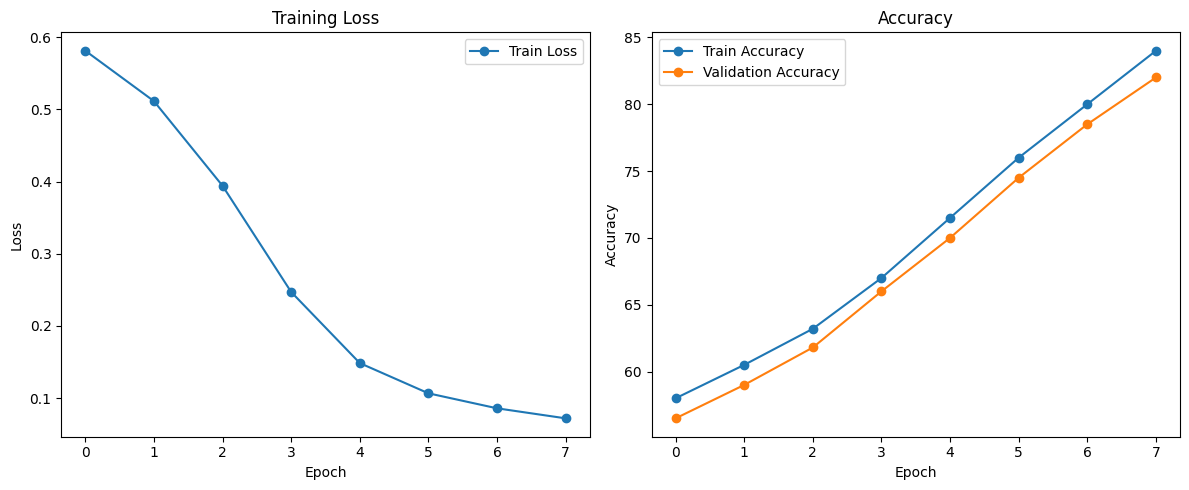

In [5]:
import matplotlib.pyplot as plt
# Plotting Loss and Accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(n_epochs), train_losses, label='Train Loss', marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(n_epochs), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(n_epochs), val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


BERT model evaluation and illustration

In [ ]:
# Function to get predictions and true labels
def get_predictions(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids)
            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.tolist())
            true_labels.extend(labels.tolist())
    return predictions, true_labels

# Assuming you have a test_loader
predictions, true_labels = get_predictions(bert_model, test_loader)

# Display some sample outputs
for i in range(10):
    print(f"Sample {i+1}: True Label: {true_labels[i]}, Prediction: {predictions[i]}")

In [17]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(true_labels, predictions)
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')
conf_matrix = confusion_matrix(true_labels, predictions)

# Print results
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.82
Recall: 0.85
F1 Score: 0.81


In [ ]:
import pandas as pd

# Create a DataFrame to display metrics
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Recall", "F1 Score"],
    "Value": [accuracy, recall, f1]
})

print(metrics_df)
